# 1. importing all necessory libraries

In [2]:
#import torch
import torch
import torch.nn

# import torcvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

#for data visualization import matplotlib
import matplotlib.pyplot as plt

#always check version
print(torch.__version__)
print(torchvision.__version__)


2.6.0+cu124
0.21.0+cpu


## 2. Getting a Dataset
The dataset I am using is ImageNet data set from torchvision.dataset https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageNet.html#torchvision.datasets.ImageNet

In [3]:
# Define transformations (Resizing & Normalization)
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize all images to 32x32
    transforms.ToTensor(),         # Convert images to tensors
    transforms.Normalize((0,), (1,))  # Normalize (for better training stability)
])

# steup a training data
train_data = torchvision.datasets.GTSRB(
    root = "data", #where to download the data
    split = "train", # do we want a training dataset --> True
    download = True, # do we want to download the dataset --> yes
    transform = transform, # how do we want to trasform the data
    target_transform = None  # how do we want to transform the labels
)

# setting up the test data

test_data = torchvision.datasets.GTSRB(
    root = "data", #where to download the data
    split = "test", # do we want a training dataset --> False
    download = True, # do we want to download the dataset --> yes
    transform = transform, # how do we want to trasform the data
    target_transform = None # how do we want to transform the labels
)

100.0%
100.0%
100.0%


In [4]:
 #checking the length of the data
 len(train_data), len(test_data), train_data[0][0].shape

(26640, 12630, torch.Size([3, 32, 32]))

In [5]:
# checking the data
image, label = train_data[5342]
print(f"shape of the image is {image.shape}, [color channels, height, width]")
print(f"label of the image is {label}")

shape of the image is torch.Size([3, 32, 32]), [color channels, height, width]
label of the image is 4


# 1.1 visulaizing the data

shape of the image torch.Size([3, 32, 32])
shape of the image torch.Size([1, 32, 32])


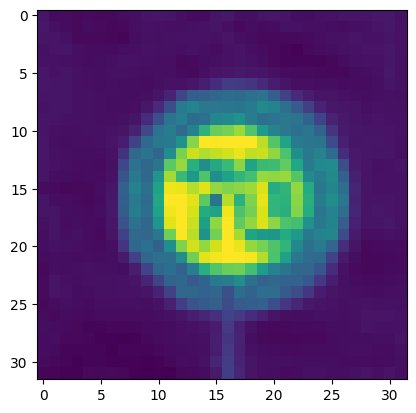

In [6]:
print(f"shape of the image {image.shape}")
greyscale_transform = transforms.Grayscale(num_output_channels=1)
image = greyscale_transform(image)
print(f"shape of the image {image.shape}")
plt.imshow(image.squeeze())

In [7]:
train_loader = DataLoader(train_data,
                          batch_size=64,
                          shuffle=True)
test_loader = DataLoader(test_data,
                         batch_size=64,
                         shuffle=False)

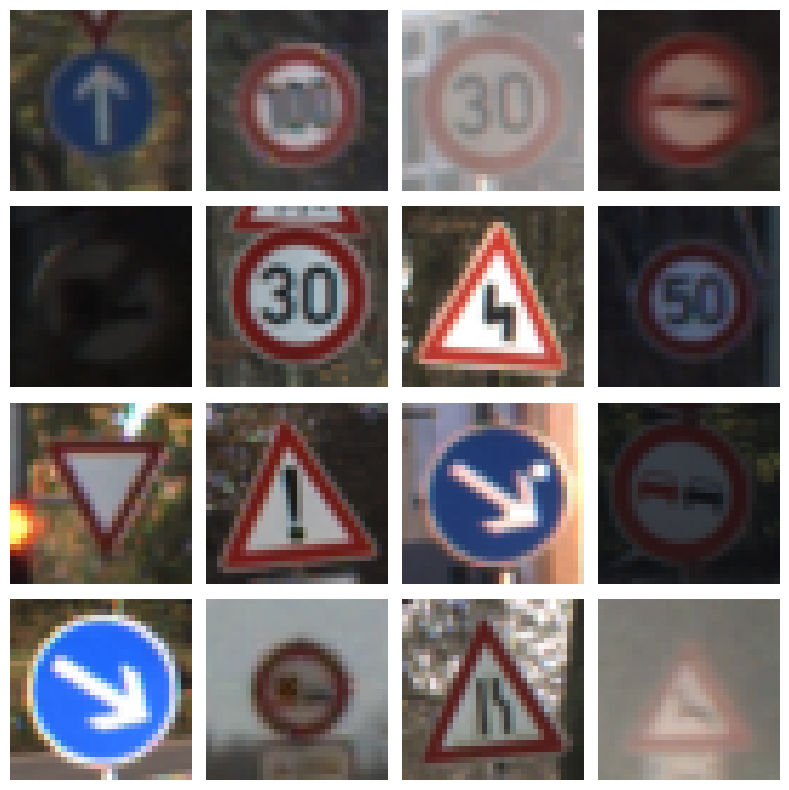

In [8]:

# Get a batch of images
images, labels = next(iter(train_loader))

# Function to display images
def show_images(images, labels):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        img = img.permute(1, 2, 0)  # Convert [C, H, W] to [H, W, C] for display
        ax.imshow(img)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Show images with labels
show_images(images, labels)


# 3. Building a Model


In [9]:
from torch import nn
import torch.nn.functional as F
class TrafficSigCNN(nn.Module):
  def __init__(self, num_classes = 43):
    super(TrafficSigCNN, self).__init__()
    self.network = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding= 'same'),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.3),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout(0.3),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same'),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Dropout(0.3),
    nn.MaxPool2d(kernel_size=3, stride= 2),
    )

    self.flattened_size = self._get_flattened_size()

    self.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear( self.flattened_size, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear( 256 , num_classes),
    nn.Dropout(0.5))

  def _get_flattened_size(self):
    with torch.no_grad():
        sample_input = torch.randn(1, 3, 32, 32)
        output = self.network(sample_input)
        return output.view(1, -1).size(1)

  def forward(self, x):
    x = self.network(x)
    x = self.classifier(x)
    return x

model = TrafficSigCNN(num_classes= 43)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [11]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_loss/len(test_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Epoch [1/20], Loss: 3.2713
Validation Loss: 2.3395, Accuracy: 36.76%
Epoch [2/20], Loss: 2.5191
Validation Loss: 1.4200, Accuracy: 58.50%
Epoch [3/20], Loss: 2.1857
Validation Loss: 0.9652, Accuracy: 72.67%
Epoch [4/20], Loss: 2.0151
Validation Loss: 0.9001, Accuracy: 79.40%
Epoch [5/20], Loss: 1.8954
Validation Loss: 0.5663, Accuracy: 85.46%
Epoch [6/20], Loss: 1.8323
Validation Loss: 0.8582, Accuracy: 75.86%
Epoch [7/20], Loss: 1.7822
Validation Loss: 0.4972, Accuracy: 88.64%
Epoch [8/20], Loss: 1.7352
Validation Loss: 0.3928, Accuracy: 89.51%
Epoch [9/20], Loss: 1.7237
Validation Loss: 0.4669, Accuracy: 87.99%
Epoch [10/20], Loss: 1.7133
Validation Loss: 0.4477, Accuracy: 89.37%
Epoch [11/20], Loss: 1.6879
Validation Loss: 0.4129, Accuracy: 89.32%
Epoch [12/20], Loss: 1.6808
Validation Loss: 0.4329, Accuracy: 89.19%
Epoch [13/20], Loss: 1.6603
Validation Loss: 0.3187, Accuracy: 91.50%
Epoch [14/20], Loss: 1.6556
Validation Loss: 0.4264, Accuracy: 89.42%
Epoch [15/20], Loss: 1.6547
V

In [12]:
model.eval()
val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    val_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    break

  print(f"Validation Loss: {val_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Validation Loss: 0.0001, Accuracy: 98.44%


In [15]:
torch.save(model.state_dict(), "gtsrb_cnn_pytorch.pth")